In [1]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv("./dataset/heart.csv")

In [3]:
df = pd.read_csv("./dataset/heart.csv")

# Encode categorical features
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape X for LSTM input
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [4]:
def objective(trial):
    # Define search space for hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    # Build LSTM model
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(num_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        elif i == num_layers - 1:
            model.add(LSTM(num_units, activation='relu'))
        else:
            model.add(LSTM(num_units, activation='relu', return_sequences=True))
    
    model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate model on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    return val_acc



In [5]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Get best hyperparameters
best_params = study.best_params



[I 2024-05-24 12:53:05,013] A new study created in memory with name: no-name-67578c60-7d91-4920-a085-5cea5f063c72


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\byomo\AppData\Local\Temp\ipykernel_19340\1809393793.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


[I 2024-05-24 12:53:11,351] Trial 0 finished with value: 0.8985507488250732 and parameters: {'num_layers': 2, 'num_units': 77, 'learning_rate': 0.0045229742288453965}. Best is trial 0 with value: 0.8985507488250732.
[I 2024-05-24 12:53:20,701] Trial 1 finished with value: 0.8478260636329651 and parameters: {'num_layers': 2, 'num_units': 105, 'learning_rate': 0.00013028757952622522}. Best is trial 0 with value: 0.8985507488250732.
[I 2024-05-24 12:53:30,755] Trial 2 finished with value: 0.9130434989929199 and parameters: {'num_layers': 3, 'num_units': 222, 'learning_rate': 0.003963376770715911}. Best is trial 2 with value: 0.9130434989929199.
[I 2024-05-24 12:53:36,853] Trial 3 finished with value: 0.9057971239089966 and parameters: {'num_layers': 1, 'num_units': 61, 'learning_rate': 0.002192823145156753}. Best is trial 2 with value: 0.9130434989929199.
[I 2024-05-24 12:53:44,294] Trial 4 finished with value: 0.9202898740768433 and parameters: {'num_layers': 3, 'num_units': 127, 'learni

In [6]:
# Train final model with best hyperparameters
final_model = Sequential()
for i in range(best_params['num_layers']):
    if i == 0:
        final_model.add(LSTM(best_params['num_units'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    elif i == best_params['num_layers'] - 1:
        final_model.add(LSTM(best_params['num_units'], activation='relu'))
    else:
        final_model.add(LSTM(best_params['num_units'], activation='relu', return_sequences=True))

final_model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

final_model.fit(X_train, y_train, epochs=30, batch_size=48, verbose=1, validation_data=(X_val, y_val))

# Evaluate final model on test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)

# Predict on test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)

Epoch 1/30
14/14 [==============================] - 4s 49ms/step - loss: 0.6752 - accuracy: 0.6978 - val_loss: 0.6000 - val_accuracy: 0.8551
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.4610 - accuracy: 0.8349 - val_loss: 0.3815 - val_accuracy: 0.8406
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.3746 - accuracy: 0.8442 - val_loss: 0.3507 - val_accuracy: 0.8623
Epoch 4/30
14/14 [==============================] - 0s 11ms/step - loss: 0.3546 - accuracy: 0.8645 - val_loss: 0.3407 - val_accuracy: 0.8623
Epoch 5/30
14/14 [==============================] - 0s 11ms/step - loss: 0.3223 - accuracy: 0.8629 - val_loss: 0.3153 - val_accuracy: 0.8841
Epoch 6/30
14/14 [==============================] - 0s 11ms/step - loss: 0.3104 - accuracy: 0.8645 - val_loss: 0.3327 - val_accuracy: 0.8623
Epoch 7/30
14/14 [==============================] - 0s 11ms/step - loss: 0.3081 - accuracy: 0.8645 - val_loss: 0.2937 - val_accuracy: 0.8768
Epoch 8/30
14

In [7]:
# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy= accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred, average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8768115942028986
Precision: 0.9230769230769231
Recall: 0.8674698795180723
F1 Score: 0.8944099378881988
ROC AUC Score: 0.9320920043811609


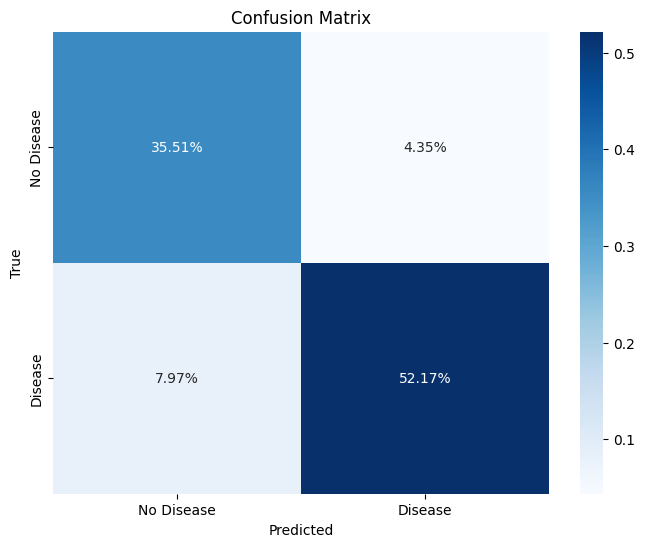

In [8]:
# Plot the confusion matrix using seaborn for better visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        55
           1       0.92      0.87      0.89        83

    accuracy                           0.88       138
   macro avg       0.87      0.88      0.87       138
weighted avg       0.88      0.88      0.88       138



## Saving the Model

In [10]:
'''# Save the model
final_model.save('./models/LSTM.h5')'''


In [ ]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


In [ ]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report


In [ ]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
